В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib notebook

### Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [2]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [3]:
1/(1+np.exp(-np.dot(X, theta)))

array([9.97527377e-01, 1.19202922e-01, 7.31058579e-01, 3.05902227e-07])

In [4]:
def probability(theta, X):
    result = 1/(1+np.exp(-np.dot(X, theta)))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [5]:
threshold =.5
prob =  probability(theta, X)
result = np.array(list(map(lambda x: 0 if x<threshold else 1, prob)))
result

array([1, 0, 1, 0])

In [6]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = np.array(list(map(lambda x: 0 if x<threshold else 1, prob)))
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [7]:
def logloss(theta, X, y):
#     result = (1/X.shape[0])* np.sum(np.log(1+np.exp(-y*np.dot(X, theta))))
    signed_y = np.array(list(map(lambda x: -1 if x == 0 else x, y)))
    result = (1/X.shape[0])* np.sum(np.log(1+np.exp(-signed_y*np.dot(X, theta))))
    return result

In [8]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [9]:
def gradient(theta, X, y):
    result =np.empty_like(theta)
    for j in range(result.shape[0]):
        for i in range(X.shape[0]):
            result[j] = (1/X.shape[0]) * np.sum(1/(1+np.exp(-y[i]*np.dot(X[i], theta))))*np.exp(-y[i]*np.dot(X[i], theta))*(-y[i]*X[i, j])
    
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [10]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('iterations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('iterations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [11]:
X, y = make_classification(n_samples=2000)

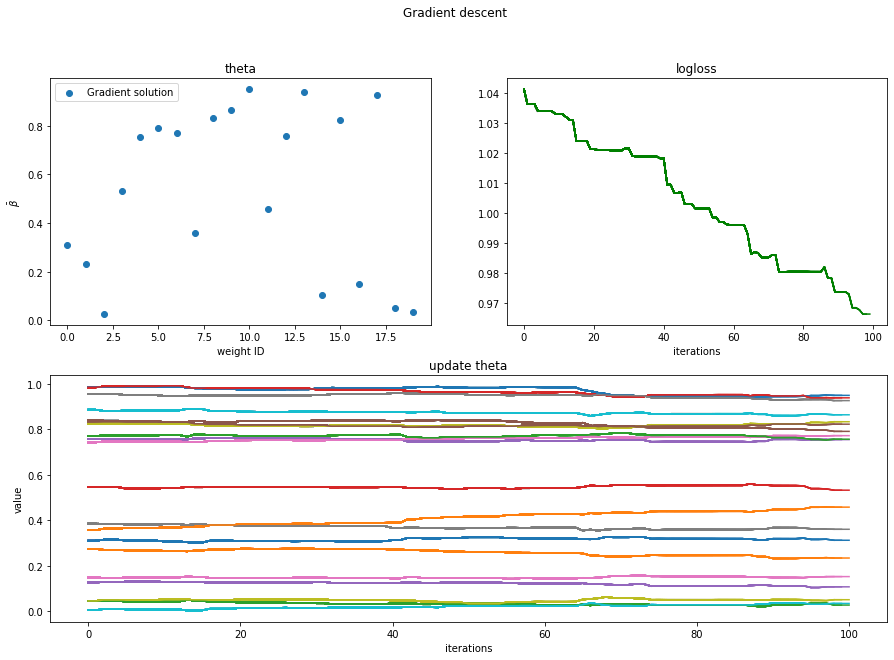

In [12]:
optimal_theta = fit(X, y)

### Тесты

In [13]:
X = pd.read_csv('weather.csv')

In [14]:
y = X.RainTomorrow.replace({'No':0, 'Yes': 1})

In [15]:
del X['RainTomorrow']
del X['Unnamed: 0']
del X['Date']
del X['Location']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [17]:
numeric_data = X_train.select_dtypes([np.number])

numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

In [18]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [20]:
pd.DataFrame(X_train.toarray())

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.669076,0.574226,0.031898,-1.501219,-1.543035,-1.299894,1.488475e+00,0.000000,0.057450,0.081425
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.093405,0.354682,-1.457149,-1.354478,-1.110387,-1.194039,-3.885845e-16,0.000000,0.104824,0.453746
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.558921,0.793771,-1.788048,-1.109909,-1.557954,-1.057940,-3.885845e-16,-1.256690,0.704893,0.289925
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.322320,-1.072357,-1.401999,-1.794701,-0.066065,-0.437933,-3.885845e-16,0.000000,0.246946,0.781389
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.762940,0.135137,0.638547,-0.963168,-1.080550,-1.466238,1.050967e+00,1.582464,0.199572,1.257960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.542630,1.342632,-0.023252,0.797727,0.381502,0.514762,6.134599e-01,0.162887,-0.100462,-0.633431
106640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.762940,-0.633268,1.024596,1.042296,0.903664,0.968426,1.488475e+00,0.636080,-0.400497,-0.856824
106641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.669076,2.989216,-0.078401,0.748813,0.262151,1.028914,6.134599e-01,1.582464,-0.163628,-0.931288
106642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-1.093405,-0.633268,-1.181399,0.015107,1.933068,2.117708,-2.615547e-01,-2.203075,-0.242584,-0.841931


#### LogisticRegression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [22]:
regs = ['l1', 'l2', 'elasticnet', 'none']

searcher = GridSearchCV(LogisticRegression(), [{"penalty": regs}], scoring="neg_mean_absolute_error", cv=10)
searcher.fit(X_train, y_train)

best_penalty = searcher.best_params_["penalty"]
print(f"Best penalty = {best_penalty}")

Best penalty = none


In [23]:
pipeline = LogisticRegression(penalty=best_penalty)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 0.1482


#### neighbors

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
n_neighbors = np.arange(3, 8, 2)
leafsize = np.arange(20, 41, 10)

searcher = GridSearchCV(KNeighborsClassifier(), [{"n_neighbors": n_neighbors}], scoring="neg_mean_absolute_error", cv=2)
searcher.fit(X_train, y_train)

best_n = searcher.best_params_["n_neighbors"]
print(f"Best n = {best_n}")
# best_leafsize = searcher.best_params_["leaf_size"]
# print(f"Best leafsize = {best_leafsize}")

In [ ]:
pipeline = KNeighborsClassifier(n_neighbors=best_n, leaf_size=best_leafsize)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

#### Naive Bayes

In [272]:
from sklearn.naive_bayes import GaussianNB

In [278]:
pipeline = GaussianNB()

model = pipeline.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test.toarray())
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

Test MAE = 0.2039


#### Собственная реализация

In [286]:
model = fit(X_train.toarray(), y_train, plot=False)
y_pred = binary_class_prediction(model, X_test.toarray())
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))

KeyError: 0